# Second session - To solve the third tasks of the proposed project!

To start we should load the pandas packages as pd along with the matplotlib.pyplot, as we want to take a look on the data; and numpy, as some calculations may be needed.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Third task (to segment the database according to the activities and find the average response to each activity)


After we prepared the database in the first two tasks of this project, now we should have a file containing the data from all the modules during the whole period of experimentation. The first step for this task is to load this into our workspace and make sure everything is as it should be, i.e, all 79 colums are present and named and in the float64 datatype, except from the 'Time' column which should be in the datetime format with the correct timezone ('UTC+01:00'). The code below should make sure of that:

In [ ]:
base = pd.read_csv('/content/drive/MyDrive/projet_data_science_m2/projet_data/data/mergeData.csv', sep=',')
base['Time'] = pd.to_datetime(base['Time']).dt.tz_convert('UTC+01:00')
print(base.dtypes)
print(base)

Time                      datetime64[ns, UTC+01:00]
RH_mod1                                     float64
Temperature_mod1                            float64
TGS4161_mod1                                float64
MICS2714_mod1                               float64
                                    ...            
piano_GM702BI00_thin                        float64
piano_GM802BI00_thin                        float64
piano_MICS5524I00_thin                      float64
piano_MICS2714I00_thin                      float64
piano_MICS5914I00_thin                      float64
Length: 79, dtype: object
                            Time    RH_mod1  Temperature_mod1  TGS4161_mod1  \
0      2022-11-14 15:20:20+01:00  34.907333         25.290000      0.502333   
1      2022-11-14 15:20:30+01:00  35.026000         25.286667      0.545667   
2      2022-11-14 15:20:40+01:00  35.231333         25.293333      0.552667   
3      2022-11-14 15:20:50+01:00  35.008000         25.260000      0.555500   
4      

This should procude something similar to this:

---
```
Time                datetime64[ns, UTC+01:00]
RH_mod1                               float64
Temperature_mod1                      float64
TGS4161_mod1                          float64
MICS2714_mod1                         float64
                              ...
piano_VOCM31I00                       float64
piano_TGS2600I00                      float64
piano_TGS2602I00                      float64
piano_SB5100I00                       float64
piano_SBAQ106I00                      float64
Length: 79, dtype: object
```



The second step is to step is to load the calendar file which contains the labels of each activity, as well as their start and end time. This file is called 'activites.xlsx' and it contains a few tabs containing a short explanation of the activities in the tab 'Activities', the transition probability bewteen the activties in tab 'Transition table', the calendar of activities (the part that interests us) in tab 'Done so far', and some irrelevant data for us in tab 'Individual Measurements'.

In [ ]:
# On charge le fichier activities.xlxs avec les 3 colonnes souhaitées : 'activity', 'Started', 'Ended'
calendar = pd.read_excel('/content/drive/MyDrive/projet_data_science_m2/TP_Data_2024FISA/activites.xlsx', sheet_name='Done so far', usecols=['activity', 'Started', 'Ended'])

calendar['Started'] = pd.to_datetime(calendar['Started']).dt.tz_localize('UTC').dt.tz_convert('UTC+01:00')
calendar['Ended'] = pd.to_datetime(calendar['Ended']).dt.tz_localize('UTC').dt.tz_convert('UTC+01:00')

# On enleve les cellules 'NaN'
calendar = calendar.dropna().reset_index(drop=True)
print(calendar.dtypes)

activity                       object
Started     datetime64[ns, UTC+01:00]
Ended       datetime64[ns, UTC+01:00]
dtype: object


As the activity file is a .xlsx file, pd.read_csv won't work on it. For that, take a look on the the pd.read_excel() function (https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html#pandas-read-excel). You only need to load the 'Done so far' tab, so don't worry about the rest of the tabs.

This tab contains the name of the column 'activity' which represents the activity being executed between the times represented by the columns 'Started' and 'Ended', as well as some comments about what happened during the execution in the column 'comments', don't worry about this columns, you don't need to load it.

'Started' and 'Ended' should be in the same format as the 'Time' column from the database, i.e, datetime in the UTC+01:00 timezone.

Remember to drop the NaN values from the resulting dataframe after you import it to the workspace.

If you check the datatypes inside the dataframe you should get something like this:

```
activity                       object
Started     datetime64[ns, UTC+01:00]
Ended       datetime64[ns, UTC+01:00]
dtype: object
```



And if you check the dimensions of the dataframe (df.shape) it should result in *(273,3)* (if you didn't load the 'comments' column)

In [ ]:
print(calendar.shape)

(273, 3)


# Segmentation of the activities

After loading the database and the calendar into the workspace, the segmentation is nothing more than extracting the segments of the database between the 'Started' and 'End' time for each activity. I suggest that you store each segmented activity into a list corresponding to its name, i.e. all activities names "AS1" are stored in a list called "AS1grouped", for example. I also suggest that you keep track of the length of the activities for the next stage. For the segmentation of each activity the piece of code below should do the trick (example for activity "AS1"), but feel free to perform it as you may see fit (creating a function to do that, for example):

In [ ]:
def segmentActivity(base, activity_name, calendar):
    act_instances = []
    len_instances = []
    for idact, act in enumerate(calendar['activity']):

        start = calendar['Started'][idact].tz_convert('UTC+01:00')
        end = calendar['Ended'][idact].tz_convert('UTC+01:00')
        if act == activity_name:
            act1new = base[(base['Time'] >= start) & (base['Time'] <= end)].reset_index(drop=True).sort_values(
                by='Time').drop(columns='Time').dropna().reset_index(drop=True)
            act_instances.append(act1new)
            len_instances.append(len(act1new))

    return act_instances, len_instances


In [ ]:
# Récupération des noms de chaque activité dans calendar['activity']
list_activities = calendar['activity'].drop_duplicates().tolist()
print(list_activities)

# Pour chaque activité du calendrier, la méthode segmentActivity est executée,
# affectant les instances (segments de l'activité) aux tableaux segment_act et les longueurs de toutes les instances par activité à segment_len
segment_act = []
segment_len = []
for name_activity in list_activities:
    name_act, len_act = segmentActivity(base, name_activity, calendar)
    segment_len.append(len_act)
    segment_act.append(name_act)
print("segment ...DONE")

['Saber', 'Aera', 'Nett', 'Asp', 'AS1', 'Bougie', 'SdB', 'BricoP', 'BricoC', 'Oeuf']
segment ...DONE


In [ ]:
# Chaque index de segment_act represente l'ensemble des activités segmenté en foncion du nom.
# En d'autres termes, si on souhaite afficher toute les activités segmentées de 'Sdb' par exemple, voici l'execution à faire :
for index in range(len(list_activities)):
  if list_activities[index] == 'SdB':
    print(f"Segmented Acivities from {list_activities[index]}")
    print(segment_act[index])
    print(f"Segmented Acivities lengths from {list_activities[index]}")
    print(segment_len[index])

Segmented Acivities from SdB
[       RH_mod1  Temperature_mod1  TGS4161_mod1  MICS2714_mod1  TGS2442_mod1  \
0    41.372667         24.816667      0.594667       0.241000    828.703667   
1    41.160000         24.800000      0.594500       0.241000    811.342500   
2    41.266333         24.790000      0.595000       0.241000    807.870333   
3    41.363667         24.796667      0.594667       0.241000    835.648000   
4    41.299667         24.866667      0.594667       0.241000    805.555333   
..         ...               ...           ...            ...           ...   
356  40.470000         26.176667      0.588667       0.264333    973.765333   
357  40.577333         26.120000      0.588000       0.264000    952.932333   
358  40.585333         26.203333      0.588000       0.264667    973.765333   
359  40.503000         26.220000      0.588000       0.265000    966.435500   
360  40.530000         26.173333      0.588000       0.265333    955.246667   

     MICS5524_mod1  T

# Finding the average activity signature

After segmenting the activities, you should have a list of instances of activities for all 10 activities. Each instance is a moment in which one of the volunteers performed the activity during the experimental period. Now the final step of this task is to calculate the average signature of each activity. A trivial (and naïve) way of doing that is by performing a mean() inside the list for each activity. If that was possible it would be great, but it isn't so you have to find a solution to that. **Here you have the freedom to find a solution any way you want, really, as long as the result is an average time series for each activity, and you explain well how you did it**. Obviously I have a solution ready (but it's not as fun as find by yourself), so feel free to ask questions and I'll point you in the right direction.

As an organizational tip, I propose you define an averageSignature function that takes as input the list which groups a given activity and the average length of the instances of activities and returns the average signature, such as :

In [ ]:
# AS1
# avgAS1 = averageSignature(as1_instances, len_as1)

In [ ]:
""" Fonction effectuant la moyenne pour chaque activité
    Resultat : Une seule instance moyenne """

def averageSignature(activity_instances, avg_length):
    average_init_by_length = []
    # On ne fait la moyenne qu'avec les instances dont avg_length est supérieur et égale à la longueur de l'instance
    for instance in activity_instances:
        if len(instance) >= avg_length:
            average_init_by_length.append(instance)

    # Début de la création du dataframe contenant la signature moyenne
    col_name = average_init_by_length[0].columns
    df = pd.DataFrame()
    for columns in col_name:
        df[columns] = average_columns(average_init_by_length, columns, avg_length)

    return df

""" Fonction effectuant la moyenne pour une colonne 'col_name' passée en paramètre """

def average_columns(activity_instance, col_name, avg_length):
    average_result = []
    for i in range(avg_length):
        sum_act = 0
        # Addition de colonne [i] pour chaque instance
        for instance in activity_instance:
            sum_act += instance[col_name][i]
        # Moyenne entre la somme et avg_length
        mean_act = sum_act / avg_length
        # Résultat ajouté dans average_result
        average_result.append(mean_act)

    return average_result

In [ ]:
# A ce niveau, on établit la moyenne de la longueur de chaque activité pour toutes les segmentations
seg_len = []
for len_act in segment_len:
    seg_len.append(sum(len_act) // len(len_act))

average_result = []
for index in range(len(list_activities)):
    average_result.append(averageSignature(segment_act[index], seg_len[index]))
print("average ...DONE")

average ...DONE


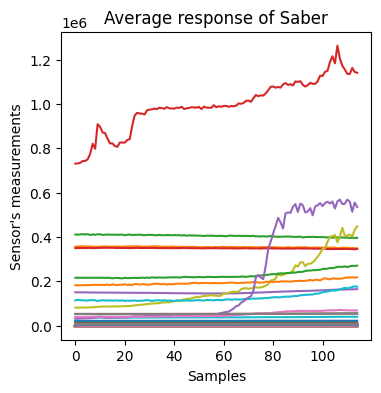

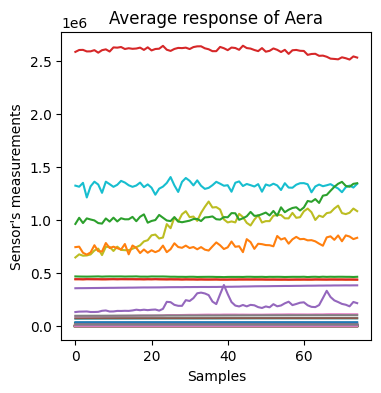

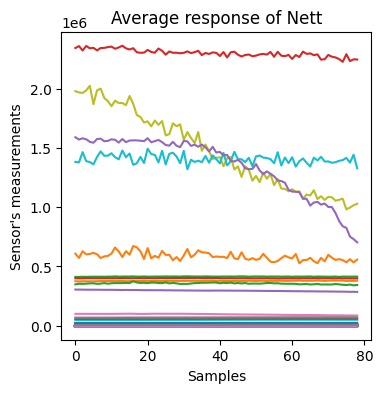

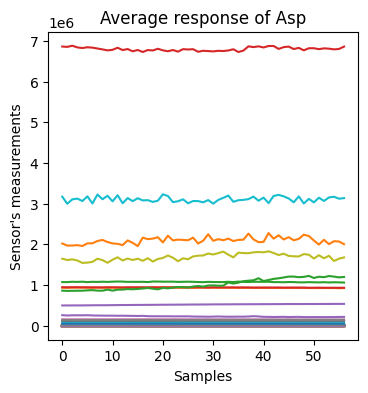

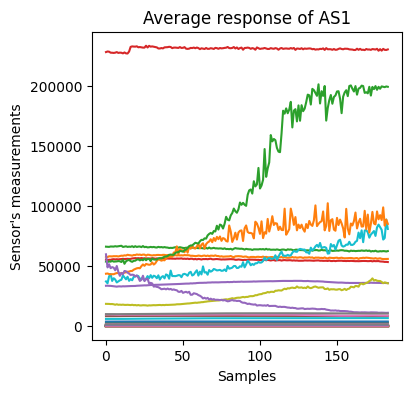

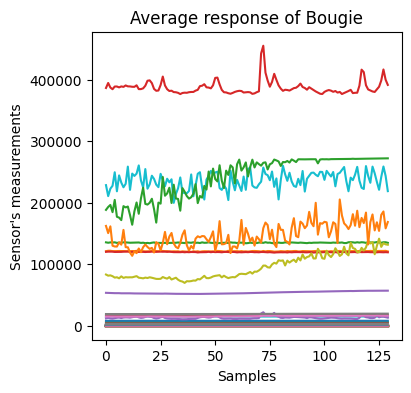

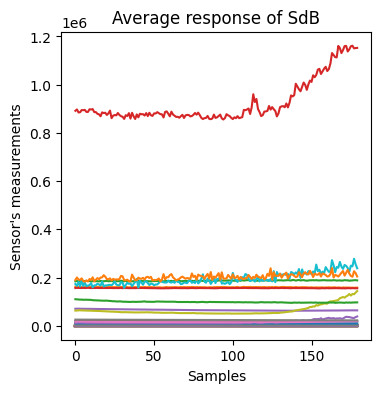

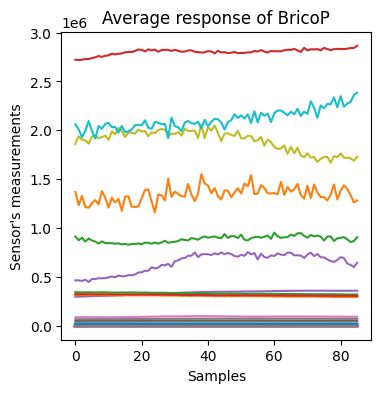

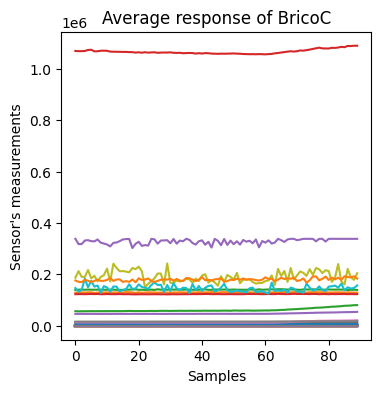

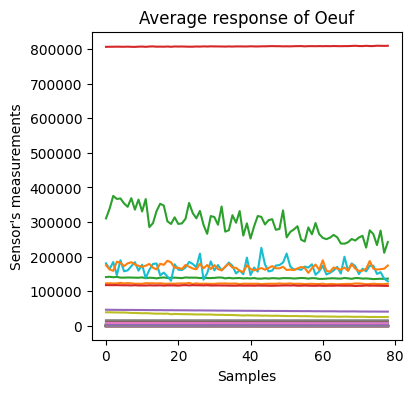

In [ ]:
# Affichage des courbes avec la signature moyenne
for i in range(len(average_result)):
    plt.figure(figsize=(4, 4))
    plt.plot(average_result[i])
    plt.title(f'Average response of {list_activities[i]}')
    plt.xlabel('Samples')
    plt.ylabel('Sensor\'s measurements')
    plt.show()

A possible answer for this task is represented in the figure below (only 4 activities shown):
 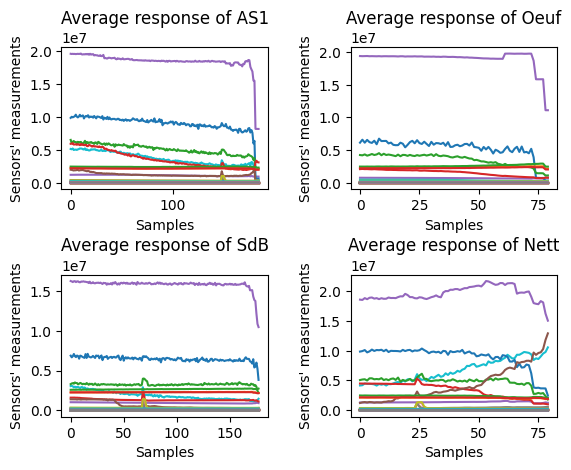
